# LSTM Time Series: Covid-19 Forecasting

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. 데이터 불러오기

In [2]:
covid = pd.read_csv('../../data/covid19_confirmed_global.csv')
covid.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,47851,48053,48116,48229,48527,48718,48952,49161,49378,49621
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,45188,46061,46863,47742,48530,49191,50000,50637,51424,52004
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,90014,90579,91121,91638,92102,92597,93065,93507,93933,94371
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,7162,7190,7236,7288,7338,7382,7382,7446,7466,7519
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,15804,15925,16061,16161,16188,16277,16362,16407,16484,16562


In [3]:
# 한국 감염자 수 데이터만 불러오기
korea = covid[covid['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
korea

C:\Users\parkm\AppData\Local\Temp\ipykernel_17004\1840496425.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  korea.index = pd.to_datetime(korea.index)


,157
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,3
...,...
2020-12-14,44364
2020-12-15,45442
2020-12-16,46453
2020-12-17,47515


In [4]:
korea.shape

(332, 1)

## 2. 한국 데이터 EDA

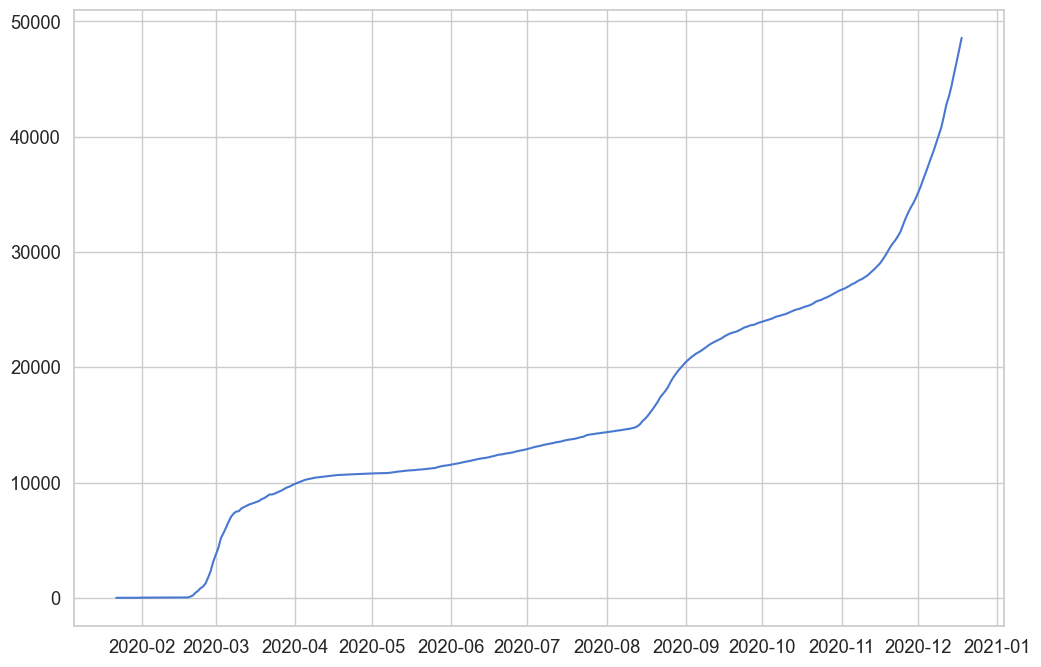

In [5]:
plt.figure(figsize=[12, 8])
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.plot(korea)
plt.show()

In [6]:
# 일별 감염자로 추출
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')
daily_cases

,157
2020-01-22,1
2020-01-23,0
2020-01-24,1
2020-01-25,0
2020-01-26,1
...,...
2020-12-14,880
2020-12-15,1078
2020-12-16,1011
2020-12-17,1062


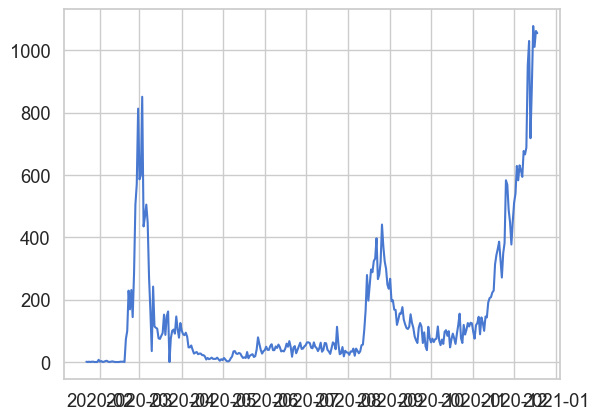

In [7]:
plt.plot(daily_cases)
plt.show()

## 3. Time Series 데이터 전처리

### 3.1 Time Sequence

In [8]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

In [9]:
X.shape

(327, 5, 1)

In [10]:
pd.DataFrame(X[:,:,0])

,0,1,2,3,4
0,1,0,1,0,1
1,0,1,0,1,1
2,1,0,1,1,0
3,0,1,1,0,0
4,1,1,0,0,0
...,...,...,...,...,...
322,666,688,950,1030,718
323,688,950,1030,718,880
324,950,1030,718,880,1078
325,1030,718,880,1078,1011


### 3.2 Train/Val/Test Split

In [11]:
train_size = int(327 * 0.8)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

### 3.3 MinMaxScaler

In [12]:
MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)

X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)

X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

### 3.4 Torch Tensor 변환

In [13]:
import torch

def make_tensor(array):
    return torch.from_numpy(array).float()

X_train = make_tensor(X_train)
y_train = make_tensor(y_train)

X_val = make_tensor(X_val)
y_val = make_tensor(y_val)

X_test = make_tensor(X_test)
y_test = make_tensor(y_test)

## 4. LSTM Time Series

### 4.1 Basic Model

In [15]:
import torch.nn as nn

# 기본 Model 참고
class LSTM0(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

### 4.2 Mid Model

In [17]:
# forward relu
from torch import nn

class LSTM1(nn.Module):
    def __init__(self):
        super(LSTM1,self).__init__()
        self.lstm = nn.LSTM(input_size=1,hidden_size=5,num_layers=1,batch_first=True)
        self.fc1 = nn.Linear(in_features=5,out_features=1)

    def forward(self,x):
        output,_status = self.lstm(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

model = LSTM1()

### 4.2 LSTM Model

In [18]:
from torch import nn, optim

class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

### 4.3 Training

In [19]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #L1Loss=MAE Loss
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    
    for t in range(num_epochs):
        epoch_loss = 0
        for idx, seq in enumerate(train_data): 
            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()
        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:
            with torch.no_grad():
                val_loss = 0
                for val_idx, val_seq in enumerate(val_data):
                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :
                    print('\n Early Stopping')
                    break
        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')
            
    return model, train_hist, val_hist

In [20]:
model_lstm = LSTM(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1)
print(model_lstm)

LSTM(
  (lstm): LSTM(1, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


In [21]:
model_lstm, train_hist, val_hist = train_model(
    model_lstm,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50)

Epoch 0 train loss: 0.08467356783562693 val loss: 0.0472203865647316
Epoch 10 train loss: 0.032689027518562085 val loss: 0.03414301946759224
Epoch 20 train loss: 0.032559265528887625 val loss: 0.03243739530444145
Epoch 30 train loss: 0.03268276013780057 val loss: 0.03306417167186737
Epoch 40 train loss: 0.03259286354831152 val loss: 0.03251414746046066
Epoch 50 train loss: 0.032316437027670473 val loss: 0.033000100404024124
Epoch 60 train loss: 0.03259848016563988 val loss: 0.03266565501689911
Epoch 70 train loss: 0.03220883580335056 val loss: 0.032897673547267914
Epoch 80 train loss: 0.032646663853598906 val loss: 0.03258887678384781
Epoch 90 train loss: 0.03234944395610342 val loss: 0.03221794217824936


### 4.4 Loss Visualization

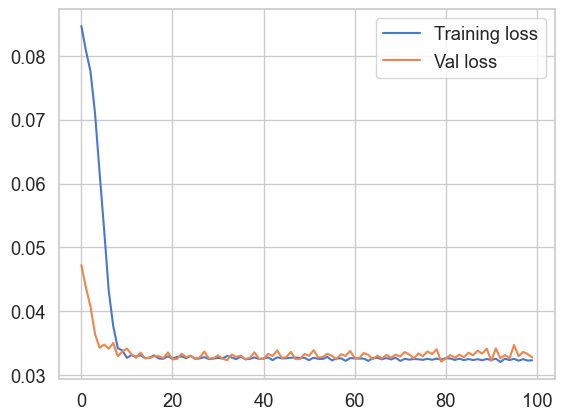

In [22]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

### 4.5 Inference & Evaluate

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(y_test, y_pred):
    print('* MAE:', mean_absolute_error(y_test, y_pred))
    print('* RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('* R_Square:', r2_score(y_test, y_pred))

In [24]:
pred_dataset = X_test

with torch.no_grad():
    preds_lstm = []
    for _ in range(len(pred_dataset)):
        model_lstm.reset_hidden_state()
        y_test_pred = model_lstm(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds_lstm.append(pred)

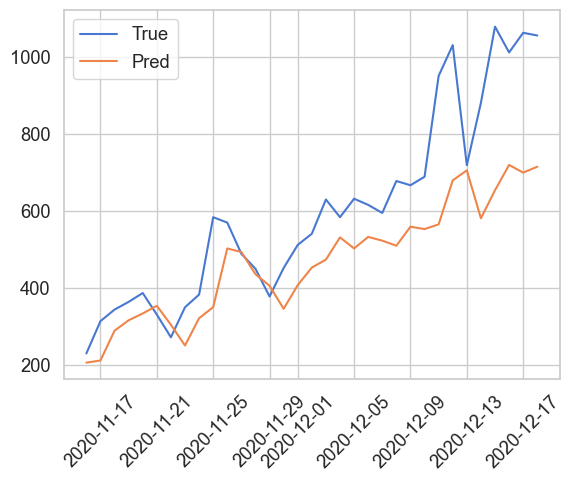

In [25]:
plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(daily_cases.index[-len(preds_lstm):], np.array(preds_lstm) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In [26]:
evaluate(np.array(y_test)*MAX, np.array(preds_lstm)*MAX)

* MAE: 136.953443027807
* RMSE: 183.8138932337982
* R_Square: 0.452823854464553


## 5. CNN-LSTM Time Series

### 5.1 Model

In [27]:
class CNN_LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CNN_LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size = 2, stride = 1) # 1D CNN 레이어 추가
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [28]:
model = CNN_LSTM(
    n_features=2,
    n_hidden=8,
    seq_len=seq_length,
    n_layers=1)

print(model)

CNN_LSTM(
  (c1): Conv1d(1, 2, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(2, 8)
  (linear): Linear(in_features=8, out_features=1, bias=True)
)


### 5.2 Training

In [29]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50)

Epoch 0 train loss: 0.12410594240344804 val loss: 0.05169092118740082
Epoch 10 train loss: 0.03842533438313053 val loss: 0.04165397211909294
Epoch 20 train loss: 0.03676734670150982 val loss: 0.03837298974394798
Epoch 30 train loss: 0.03639653879324852 val loss: 0.03886983543634415
Epoch 40 train loss: 0.035661786713483974 val loss: 0.035900793969631195
Epoch 50 train loss: 0.03426211605819078 val loss: 0.0355246402323246
Epoch 60 train loss: 0.03398039810434412 val loss: 0.03820359706878662
Epoch 70 train loss: 0.03406222616197448 val loss: 0.0395689383149147
Epoch 80 train loss: 0.03443264219842109 val loss: 0.03733229264616966
Epoch 90 train loss: 0.03347299743436591 val loss: 0.03619934618473053


### 5.2 Loss Visualization

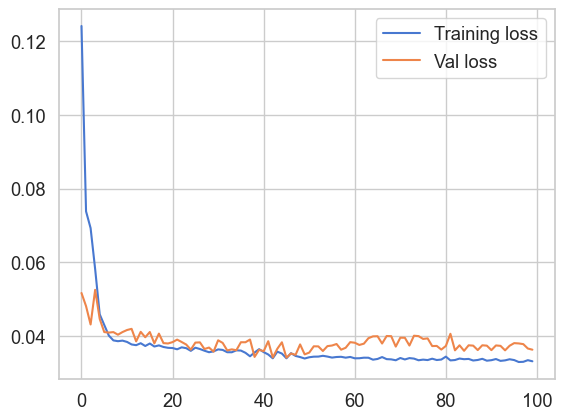

In [30]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

### 5.3 Inference & Evaluate

In [31]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

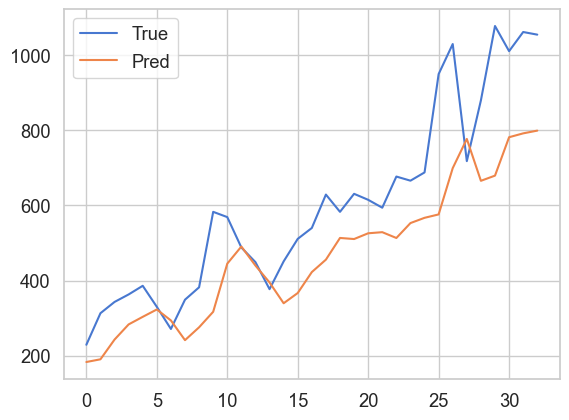

In [32]:
plt.plot(np.array(y_test)*MAX, label = 'True')
plt.plot(np.array(preds)*MAX, label = 'Pred')
plt.legend()

In [33]:
evaluate(np.array(y_test)*MAX, np.array(preds)*MAX)

* MAE: 136.82144813194418
* RMSE: 170.69845776624152
* R_Square: 0.5281220508655373
